In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import math
from sklearn.metrics import mean_squared_error

In [3]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
from tensorflow import keras

In [5]:
from sklearn.preprocessing import MinMaxScaler

# Data

In [6]:
df = pd.read_csv('MRTSSM448USN.csv', parse_dates = True, index_col = 'DATE')

In [7]:
df.columns = ['Sales']

In [8]:
# last 7 values look like outliers
df = df[:334] 

<AxesSubplot:xlabel='DATE'>

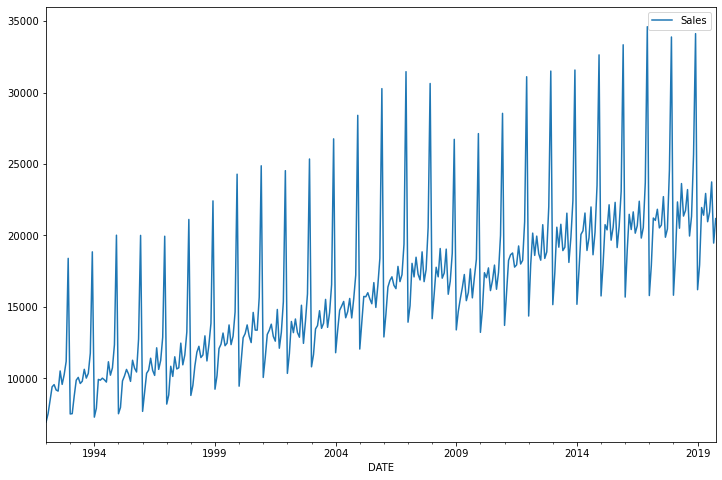

In [9]:
df.plot(figsize = (12,8))

In [10]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [11]:
# fix random seed for reproducibility
np.random.seed(7)

In [12]:
dataset = df.values
dataset = dataset.astype('float32')

In [13]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [14]:
# split into train and test sets
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size

In [15]:
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [16]:
look_back = 12
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [17]:
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Lambda
from tensorflow.keras.callbacks import EarlyStopping

In [19]:
early_stop = EarlyStopping(monitor = 'loss', patience = 2)

In [20]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [21]:
window_size = look_back
batch_size = 5
shuffle_buffer_size = 10

In [22]:
train.shape

(250, 1)

In [23]:
dataset_2 = windowed_dataset(train.reshape(train.shape[0],), window_size, batch_size, shuffle_buffer_size)

In [73]:
model = Sequential()
model.add(LSTM(25, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2, callbacks = [early_stop])

Train on 237 samples
Epoch 1/100
237/237 - 1s - loss: 0.0260
Epoch 2/100
237/237 - 0s - loss: 0.0174
Epoch 3/100
237/237 - 1s - loss: 0.0170
Epoch 4/100
237/237 - 0s - loss: 0.0150
Epoch 5/100
237/237 - 0s - loss: 0.0139
Epoch 6/100
237/237 - 0s - loss: 0.0130
Epoch 7/100
237/237 - 1s - loss: 0.0123
Epoch 8/100
237/237 - 0s - loss: 0.0129
Epoch 9/100
237/237 - 0s - loss: 0.0117
Epoch 10/100
237/237 - 0s - loss: 0.0112
Epoch 11/100
237/237 - 0s - loss: 0.0099
Epoch 12/100
237/237 - 0s - loss: 0.0101
Epoch 13/100
237/237 - 0s - loss: 0.0090
Epoch 14/100
237/237 - 0s - loss: 0.0092
Epoch 15/100
237/237 - 0s - loss: 0.0074
Epoch 16/100
237/237 - 0s - loss: 0.0081
Epoch 17/100
237/237 - 0s - loss: 0.0079


Train Score: 2309.46 RMSE
Test Score: 3522.03 RMSE


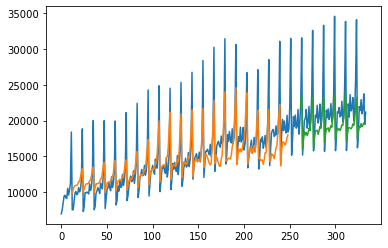

In [79]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [159]:
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])

In [160]:
model = tf.keras.models.Sequential([l0])

In [28]:
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss='mse',
              optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset_2, epochs=100)

Epoch 1/100
48/48 [==============================] - 5s 108ms/step - loss: 235495586.4867
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 212402756.5399
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 189777383.2996
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 169611282.3406
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 151831227.7777
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 136166563.9964
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 122366002.7470
Epoch 8/100
48/48 [==============================] - 0s 6ms/step - loss: 110207954.9528
Epoch 9/100
48/48 [==============================] - 0s 6ms/step - loss: 99497179.5105
Epoch 10/100
48/48 [==============================] - 0s 6ms/step - loss: 90061663.7440
Epoch 11/100
48/48 [==============================] - 0s 6ms/step - loss: 81749773.9173
Epoch 12/100
48/48 [===========

KeyboardInterrupt: 

In [28]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 10.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset_2, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
48/48 [==============================] - 5s 94ms/step - loss: 0.0427 - mae: 0.2473
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0425 - mae: 0.2469
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0424 - mae: 0.2464
Epoch 4/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0423 - mae: 0.2459
Epoch 5/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0421 - mae: 0.2453
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0420 - mae: 0.2446
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0418 - mae: 0.2439
Epoch 8/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0415 - mae: 0.2430
Epoch 9/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0413 - mae: 0.2421
Epoch 10/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0410 - mae: 0.2411
Epoch 11/100
48/48 [==============================] - 0s 6

48/48 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.0814
Epoch 88/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.0804
Epoch 89/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0797
Epoch 90/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0796
Epoch 91/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0805
Epoch 92/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0815
Epoch 93/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0081 - mae: 0.0826
Epoch 94/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0080 - mae: 0.0823
Epoch 95/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0079 - mae: 0.0811
Epoch 96/100
48/48 [==============================] - 0s 6ms/step - loss: 0.0078 - mae: 0.0797
Epoch 97/100
48/48 [==============================] - 0s 6ms/st

In [29]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [32]:
forecast = []
for time in range(len(np.array(df['Sales'])) - window_size):
  forecast.append(model.predict(np.array(df['Sales'])[time:time + window_size][np.newaxis]))

forecast = forecast[train_size-window_size:]
results = np.array(forecast)[:, 0, 0]
# invert predictions
results = scaler.inverse_transform(results.reshape(-1, 1))

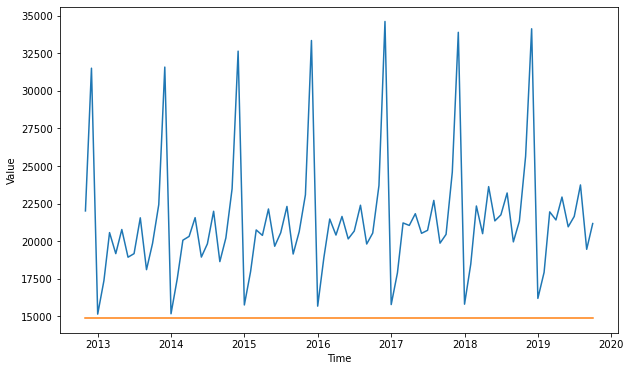

In [33]:
plt.figure(figsize=(10, 6))

time_valid = df.index[train_size:] 

plot_series(time_valid, scaler.inverse_transform(test.reshape(-1, 1)))
plot_series(time_valid, results)

In [84]:
test_size = 15
test_ind = len(df) - test_size

In [85]:
train = df.iloc[:test_ind]
test  = df.iloc[test_ind:]

<AxesSubplot:xlabel='DATE'>

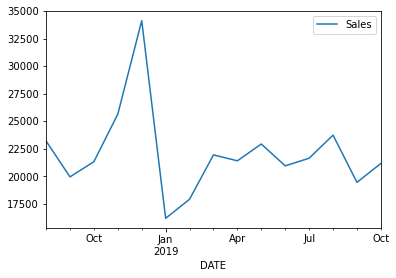

In [86]:
test.plot()

In [64]:
window_size = 25
batch_size = 15
shuffle_buffer_size = 100

In [99]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

In [100]:
dataset = windowed_dataset(np.array(train['Sales']), window_size, batch_size, shuffle_buffer_size)

In [117]:
np.array(train['Sales']).shape

(319,)

In [101]:
tf.print(dataset)

<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.int64, tf.int64)>


In [110]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(50, activation="relu"), 
    tf.keras.layers.Dense(25, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer='adam')
model.fit(dataset,epochs=100,verbose=0)


<AxesSubplot:>

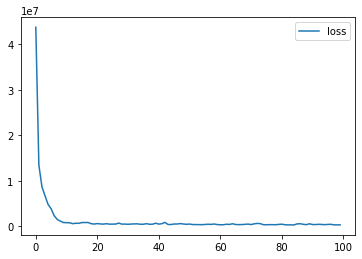

In [111]:
a = pd.DataFrame(model.history.history)
a.plot()

In [112]:
a

,loss
0,4.379563e+07
1,1.347527e+07
2,8.715273e+06
3,6.720361e+06
4,4.816394e+06
...,...
95,4.268300e+05
96,4.442311e+05
97,3.309109e+05
98,3.295089e+05


In [113]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(False)

In [114]:
forecast = []
for time in range(len(np.array(df['Sales'])) - window_size):
  forecast.append(model.predict(np.array(df['Sales'])[time:time + window_size][np.newaxis]))

forecast = forecast[test_ind-window_size:]
results = np.array(forecast)[:, 0, 0]

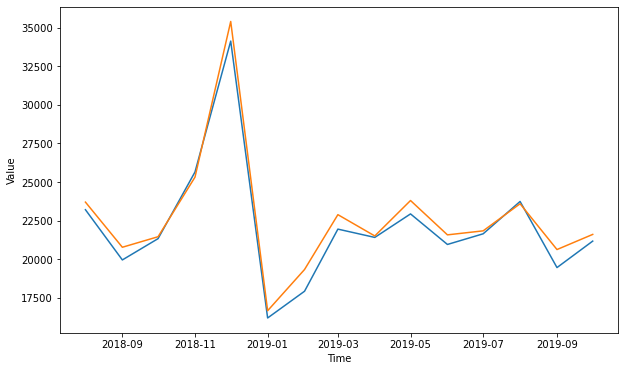

In [115]:
plt.figure(figsize=(10, 6))

time_valid = df.index[test_ind:] 

plot_series(time_valid, np.array(test['Sales']))
plot_series(time_valid, results)